In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pandas.io.formats import style

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suhack2022data/restaurant-2-products-price.csv
/kaggle/input/suhack2022data/UK Holidays.xlsx
/kaggle/input/suhack2022data/london_weather.csv
/kaggle/input/suhack2022data/indian_holidays.csv
/kaggle/input/suhack2022data/restaurant-1-orders.csv
/kaggle/input/suhack2022data/restaurant-2-orders.csv
/kaggle/input/suhack2022data/restaurant-1-products-price.csv


In [2]:
# Restaurant raw data
rest1dat = pd.read_csv("../input/suhack2022data/restaurant-1-orders.csv")
rest1price = pd.read_csv("../input/suhack2022data/restaurant-1-products-price.csv")

rest2dat = pd.read_csv("../input/suhack2022data/restaurant-2-orders.csv")
rest2price = pd.read_csv("../input/suhack2022data/restaurant-2-products-price.csv")

# London Weather Raw Data
weatherdat = pd.read_csv("../input/suhack2022data/london_weather.csv")
weatherdat.columns

# UK Holidays
ukholidat = pd.read_excel("../input/suhack2022data/UK Holidays.xlsx")

# Indian Holidays
indholidat = pd.read_csv("../input/suhack2022data/indian_holidays.csv")

rest1dat.head()


,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


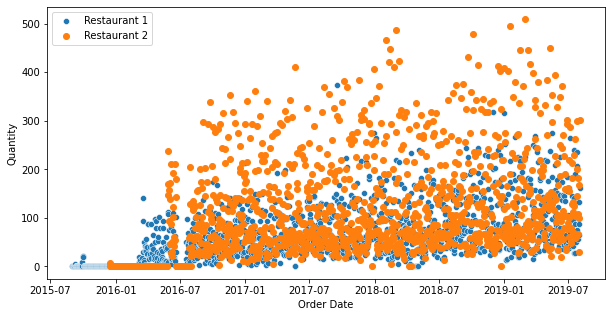

In [3]:
# Aggregating weather data. See: https://www.kaggle.com/code/mellisawood/weatherprediction

# Setting date formats
weatherdat = weatherdat.dropna(axis=0)
weatherdat['date'] = pd.to_datetime(weatherdat['date'], format = '%Y%m%d')

rest1dat['Order Date'] = pd.to_datetime(rest1dat['Order Date'], dayfirst = True)
rest2dat['Order Date'] = pd.to_datetime(rest2dat['Order Date'], dayfirst = True)

ukholidat['date'] = pd.to_datetime(ukholidat['date'], dayfirst = True).dt.date
indholidat['offdate'] = pd.to_datetime(indholidat['offdate'], dayfirst = True).dt.date

# Creating data sets for quantity analysis See: https://www.kaggle.com/code/malhardata/sales-forecasting-model

rest1grouped = rest1dat[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()
rest2grouped = rest2dat[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()

# Visualise the quantity size data as a function of time to select best data set 

plt.figure(figsize = (10,5))
sns.scatterplot(x = rest1grouped['Order Date'], y = rest1grouped['Quantity'], label = 'Restaurant 1')
plt.scatter(x = rest2grouped['Order Date'], y = rest2grouped['Quantity'],label='Restaurant 2')
plt.legend()
plt.show()


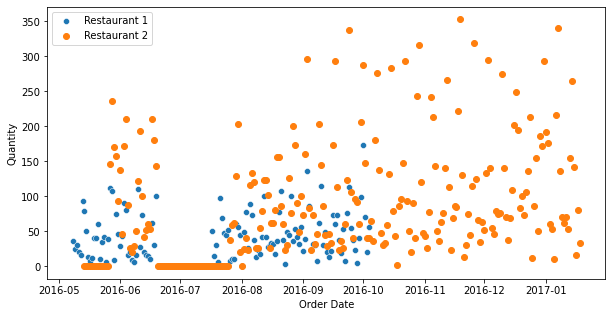

In [4]:
# Zooming in to see the precise data time to select the best quality data.
plt.figure(figsize = (10,5))
sns.scatterplot(x = rest1grouped['Order Date'].iloc[250:400], y = rest1grouped['Quantity'].iloc[250:400], label = 'Restaurant 1')
plt.scatter(x = rest2grouped['Order Date'].iloc[150:400], y = rest2grouped['Quantity'].iloc[150:400],label='Restaurant 2')
plt.legend()
plt.show()

In [5]:
# Conclusion is data with best quality is above 2016-08-01

rest1grouped = rest1grouped.loc[rest1grouped['Order Date'] >='2016-08-01' ].sort_values(by = 'Order Date',ascending= True)
rest2grouped = rest2grouped.loc[rest2grouped['Order Date'] >='2016-08-01' ].sort_values(by = 'Order Date',ascending= True)

rest1grouped.rename(columns={'Order Date':'date'}, inplace=True)
rest2grouped.rename(columns={'Order Date':'date'}, inplace=True)

weatherdat = weatherdat.loc[weatherdat['date'] >='2016-08-01']
weatherdat = weatherdat.loc[weatherdat['date'] <= '2019-08-03']

In [6]:
# Now we concatenate the data set to weather data 

rest1concat = pd.merge(rest1grouped,weatherdat,on='date',how='outer')
rest2concat = pd.merge(rest2grouped,weatherdat,on='date',how='outer')

weatherdat.head()
rest2concat.head()

,date,Quantity,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2016-08-01,0,7.0,0.0,72.0,21.9,15.6,12.1,13.0,101840.0,0.0
1,2016-08-02,25,8.0,0.0,71.0,24.7,18.0,14.1,0.2,101000.0,0.0
2,2016-08-03,40,6.0,4.7,181.0,23.5,21.5,18.3,0.0,100770.0,0.0
3,2016-08-04,23,6.0,2.0,132.0,24.1,19.3,15.1,0.0,100980.0,0.0
4,2016-08-05,116,3.0,6.5,207.0,26.4,18.4,12.8,0.0,101970.0,0.0


In [7]:
# Predict daily demand and then week demand, weather information and holidays (seasons)

# Features: {Date, Cloud Cover, Sunshine, Mean Temp, Precipitation} and Ouput: Quantity
rest1concat['date'] = rest1concat['date'].apply(lambda x: x.value)
rest2concat['date'] = rest2concat['date'].apply(lambda x: x.value)

rest1x = rest1concat[['date','cloud_cover','sunshine','mean_temp','precipitation','Quantity']]
rest2x = rest2concat[['date','cloud_cover','sunshine','mean_temp','precipitation','Quantity']]

In [8]:
# Use correlation matrix to investigate elements

def Correlation_Matrix(X,Y):
    
    corrS = X.corr()
    corrB = Y.corr()
    cmap = cmap =sns.diverging_palette(5, 250, as_cmap=True)
    def magnify():
        return [dict(selector="th",
                     props=[("font-size", "7pt")]),
                dict(selector="td",
                     props=[('padding', "0em 0em")]),
                dict(selector="th:hover",
                     props=[("font-size", "12pt")]),
                dict(selector="tr:hover td:hover",
                     props=[('max-width', '200px'),
                            ('font-size', '12pt')])
    ]

    S_corrmatrix = corrS.style.background_gradient(cmap, axis=0)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(magnify())
    B_corrmatrix = corrB.style.background_gradient(cmap, axis=0)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(magnify())
    return S_corrmatrix, B_corrmatrix

matrixS, matrixB = Correlation_Matrix(rest1x,rest1x)
matrixS

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,date,cloud_cover,sunshine,mean_temp,precipitation,Quantity
date,1.00,-0.04,0.10,0.05,0.02,0.29
cloud_cover,-0.04,1.00,-0.83,-0.16,0.23,0.04
sunshine,0.10,-0.83,1.00,0.43,-0.24,-0.05
mean_temp,0.05,-0.16,0.43,1.00,-0.06,-0.04
precipitation,0.02,0.23,-0.24,-0.06,1.00,0.04
Quantity,0.29,0.04,-0.05,-0.04,0.04,1.00


In [9]:
# # Perform GridSearch
# from sklearn.model_selection import GridSearchCV

# param_grid = [{'n_estimators': np.arange(100,1000,100)},
#               {'learning_rate': np.arange(0.01,0.5,0.05)},
#               {'max_depth': np.arange(1,11)}]

# grid_search = GridSearchCV(estimator=GradientBoostingClassifier(),
#                        param_grid=param_grid,
#                        refit=True,
#                        cv=3,
#                        scoring ='accuracy',
#                        n_jobs=-1)
# %time grid_search.fit(data_train1, target_train1.values.ravel()) 
# best_score = grid_search.best_score_
# best_params = grid_search.best_params_
# #results=grid_search.cv_results_
# sorted(grid_search.cv_results_.keys())
# best_params, best_score